# **Time series prediction with Quantum Computing**

## Replication of the paper:
"A quantum generative model for multi-dimensional time series using Hamiltonian learning -
Haim Horowitz, Pooja Rao, and Santosh Kumar Radha"

[Find the paper here:](https://arxiv.org/abs/2204.06150)

### Changes implemented in v2:
    1. Higher order transition matrix (step>1) preparation: Multiply transition matrix for step=1  k times.
    2. Quantum module:
        * Changed the order of ansatz from W†DW to WDW†
        * Measurement: returns probability of producing different states of all the system subchannels as a list.
    3. Kullback Leibler divergence loss implemented differently from paper as follows -
            L(y_true, y_pred) = y_true*log(y_true/y_pred)
       These pointwise losses are summed over all channels and target states for each element in the minibatch, and finally a mean is calculated.
    4. Cumulative degree of non-Markovianity is implemented differently from paper as follows:
            N (Φ, t) = ∑ dt*D(ρ1(t), ρ2(t))


###Changes implemented in v3.1:
    1. Basis encoding is channel specific in QNet [|0><0|s1...⊗ |i><i|sd ⊗...|0><0|env], rest of the qubits are default initialized (in 'train' mode) ; All system sub-channels are encoded and measurements are made after evolution (in 'test' mode)
    2. atomized training data format: [current_state, d, k, [T(i->0;k;d), T(i->1;k;d), ...]]
       where,
       d: channel id
       k: timestep
       s1, s2,...,sd,...: timechannel subspaces
       env: environment subspace  
    3. Changed batch_iterations parameter to epochs -
       No. of minibatches is calculated (n_minibatches ~ train_size/batch_size);
       1 epoch refers to single pass over all n_minibatches(i.e. total training set)
    4. Deleted parameter requires_grad=True while initializing loss variable in minibatch_loss() as the computational node was not properly being created for backprop and trainable parameter grads were becoming None.

In [ ]:
#Install required libraries
!pip install pennylane
!pip install pyts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 71.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 90.1 MB/s eta 0:00:00
  Attempting uninstall: autograd
    Found existing installation: autograd 1.6.2
    Uninstalling autograd-1.6.2:
      Successfully uninstalled autograd-1.6.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 4.3 MB/s eta 0:00:00


In [ ]:
# Import all libraries
import torch
import numpy as np
import pandas as pd
import math
from math import comb

import matplotlib.pyplot as plt
import matplotlib.lines as mlines

import string
import random
from scipy.stats import norm
from statsmodels.tsa.stattools import adfuller
from pyts.approximation import SymbolicAggregateApproximation
from itertools import combinations

import pennylane as qml

### 1. Generate Time Series:

In [ ]:
# Seed Torch for reproducibility and set default tensor type
GLOBAL_SEED = 2023
torch.manual_seed(GLOBAL_SEED)
torch.set_default_tensor_type(torch.DoubleTensor)

def generate_series(timestamps : int,
                    channels : int,
                    dt : float,
                    mu : torch.Tensor,
                    sigma : torch.Tensor,
                    seed : int = GLOBAL_SEED
                    ) -> torch.Tensor :

    torch.manual_seed(seed)
    # Generate Wiener increments
    dW = torch.normal(mean=0, std=dt**0.5 , size=(timestamps, channels))
    # Initialize arrays to store the time series
    X = torch.zeros((timestamps, channels))
    # Generate correlated time series using the Euler-Maruyama method
    for i in range(1, timestamps):
        X[i] = X[i - 1] + mu * dt + torch.matmul(torch.linalg.cholesky(sigma), dW[i])
    return X

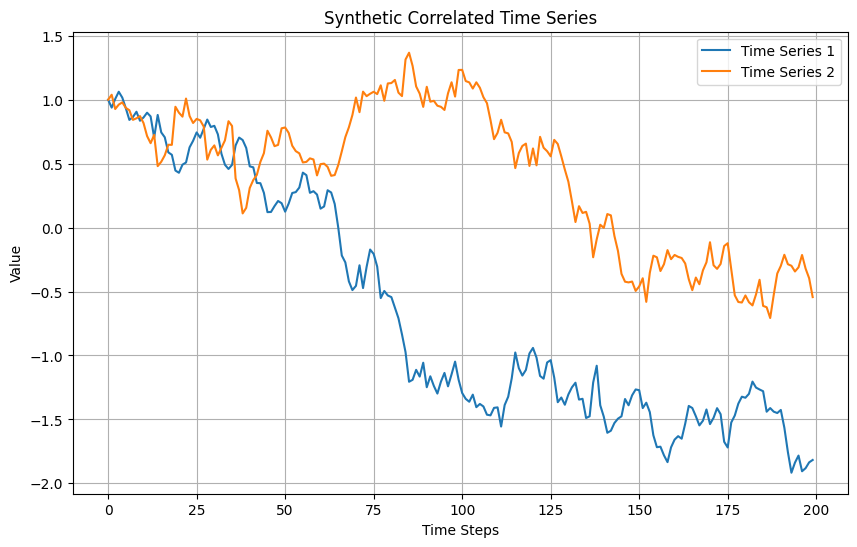

In [ ]:
# Initialize parameters
timestamps = 200
channels = 2
dt = 0.01
mu = torch.Tensor([-1,-2])
sigma = torch.Tensor([[1, -0.5],[-0.5, 1]])

X = generate_series(timestamps, channels, dt, mu, sigma)
# Extract individual series channels
X1, X2 = X[:, 0]+1, X[:, 1]+1

# Visualize the synthetic time series
plt.figure(figsize=(10, 6))
plt.plot(X1, label='Time Series 1')
plt.plot(X2, label='Time Series 2')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.title('Synthetic Correlated Time Series')
plt.legend()
plt.grid(True)
plt.show()

###2. Calculate δxi:

In [ ]:

def calculate_first_order_diff(X:torch.Tensor) -> torch.Tensor :
  X_diff = torch.diff(X, dim=-1)
  # back-fill value
  if X_diff.dim() == 1:
    X_diff_bfill = torch.cat((torch.tensor([float(X_diff[0])]),X_diff),0)
  else:
    X_diff_bfill = []
    for i in range(X_diff.shape[0]):
      X_diff_bfill.append(torch.cat((torch.tensor([float(X_diff[i][0])]),X_diff[i]),0))
    X_diff_bfill = torch.stack(X_diff_bfill)
  return X_diff_bfill

In [ ]:
def ADF_test(X, X_diff):
    '''
      Augmented Dicky Fuller Test to check for stationarity of original and differenced time series
    '''
    # Perform the ADF test
    adf_result_X = adfuller(X)
    adf_result_X1 = adfuller(X_diff)
    # Extract ADF test statistics and p-value
    adf_statistic_X, p_value_X = adf_result_X[0], adf_result_X[1]
    adf_statistic_X1, p_value_X1 = adf_result_X1[0], adf_result_X1[1]
    # Define significance level
    significance_level = 0.05
    # Check if the series is stationary
    is_stationary_X = p_value_X < significance_level
    is_stationary_X1 = p_value_X1 < significance_level
    if is_stationary_X:
      print("Original Series is already stationary")
    else:
      print("Original Series is non-stationary")
    if is_stationary_X1:
      print("First Order Differenced Series is stationary")
    else:
      print("First Order Differenced Series is still non-stationary")
    return (adf_statistic_X, p_value_X),(adf_statistic_X1, p_value_X1)

In [ ]:
X_diff = calculate_first_order_diff(X.T)
X1_diff, X2_diff = X_diff[0], X_diff[1]
print(ADF_test(X[:,0],X1_diff))
print(ADF_test(X[:,1],X2_diff))

Original Series is non-stationary
First Order Differenced Series is stationary
((-1.378130968969564, 0.5927143496871957), (-10.433556529909147, 1.5876959659095486e-18))
Original Series is non-stationary
First Order Differenced Series is stationary
((-1.0118487562691252, 0.7489182450573307), (-13.810599665519458, 8.2451326866736e-26))


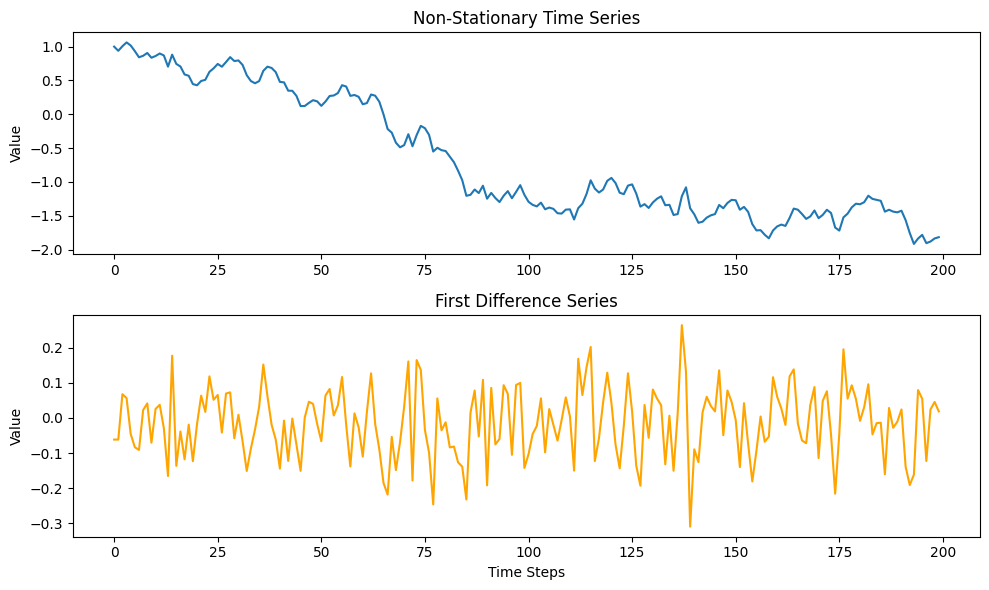

In [ ]:
# Plot the original series X1 and its first order difference
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(X1)
plt.title('Non-Stationary Time Series')
plt.ylabel('Value')
plt.subplot(2, 1, 2)
plt.plot(X1_diff, color='orange')
plt.title('First Difference Series')
plt.ylabel('Value')
plt.xlabel('Time Steps')
plt.tight_layout()
plt.show()

### Discretize 2^N:Symbolic Aggregate approXimation (SAX) algorithm

In [ ]:
class SAX():

  def __init__(self, series, n_bins, num_segments):
    self.series = series
    self.num_segments = num_segments
    self.n_bins = n_bins

  def normalize(self):
      normalized_series = []
      if not torch.is_tensor(self.series):
        self.series = torch.stack(self.series)
      if self.series.dim() == 1:
        self.series = torch.reshape(self.series, (1,-1))
      for i in range(len(self.series)):
        series_mean = torch.mean(self.series[i])
        series_std = torch.std(self.series[i])
        normalized_series.append((self.series[i] - series_mean) / series_std)
      return normalized_series

  def paa(self, normalized_series):
      paa_segments = []
      for i in range(len(normalized_series)):
          segment_length = len(normalized_series[i]) // self.num_segments
          paa_segments_i = []
          for j in range(self.num_segments):
              start = j * segment_length
              end = (j + 1) * segment_length
              segment_mean = normalized_series[i][start:end].mean()
              paa_segments_i.append(segment_mean)
          paa_segments.append(torch.stack(paa_segments_i))
      return torch.stack(paa_segments)


  def sax_transform(self):
      normalized_series = self.normalize()
      paa_segments = self.paa(normalized_series)
      # SAX transformation
      sax = SymbolicAggregateApproximation(n_bins=self.n_bins, strategy='normal', alphabet='ordinal')
      X_sax = sax.fit_transform(paa_segments)
      return X_sax

  def plot(self, channel):
    X1_diff_norm = self.normalize()
    paa_segments = self.paa(X1_diff_norm)
    X_sax = self.sax_transform()
    # Compute gaussian bins
    bins = norm.ppf(np.linspace(0, 1, self.n_bins + 1)[1:-1])
    '''
    Alternatively, the breakpoints can be distributed evenly within a custom range
    (eg. -0.43 to 0.43) to map the PAA segments to the desired number of bins.
    '''
    # Store the results for the different time series
    bottom_bool = []
    for i in range(len(paa_segments)):
      bottom_bool.append(np.r_[True, X_sax[i, 1:] > X_sax[i, :-1]])
    n_timestamps = len(X1_diff_norm[channel])
    segment_length = (n_timestamps+1) // self.num_segments
    # Plot original series
    plt.figure(figsize=(8, 4))
    plt.plot(list(range(n_timestamps)), np.array(X1_diff_norm[channel]), marker = '.', linewidth=0.8, label='Original')
    # Plot discretized series
    plt.plot(list(range(segment_length//2,n_timestamps,segment_length)), np.array(paa_segments[channel]), '*--', linewidth=0.8, color='black')
    # Plot SAX symbols and horizontal bin segments
    for x, y, s, bottom in zip(range(segment_length//2,n_timestamps,segment_length), np.array(paa_segments[channel]), np.array(X_sax[channel]), np.array(bottom_bool[0])):
      va = 'bottom' if bottom else 'top'
      plt.text(x, y, s, ha='center', va=va, fontsize=10, color='black')
    plt.hlines(bins, 0, n_timestamps, color='r', linestyles='--', linewidth=0.6)
    sax_legend = mlines.Line2D([], [], color='black', marker='*', label='SAX - {0} bins'.format(n_bins))
    first_legend = plt.legend(handles=[sax_legend], fontsize=8, loc=(0.76, 0.86))
    ax = plt.gca().add_artist(first_legend)
    plt.legend(loc=(0.76, 0.93), fontsize=8)
    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Value', fontsize=12)
    plt.title('Symbolic Aggregate approXimation', fontsize=16)
    plt.show()


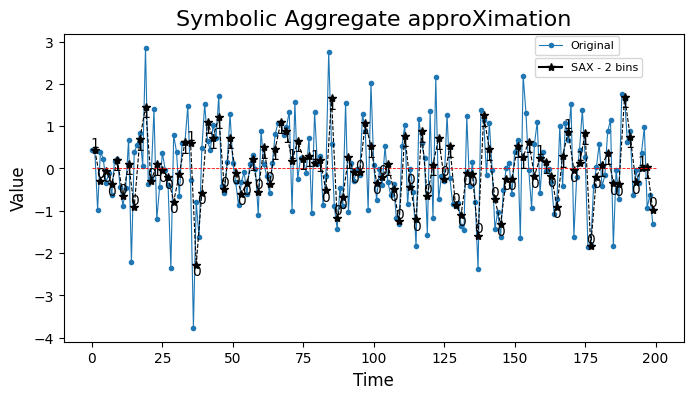

In [ ]:
# SAX parameters
n_bins = 2           # horizontal slicing
num_segments = 100     # vertical slicing

# Perform SAX transformation and visualize different channels
sax = SAX(X_diff, n_bins, num_segments)
sax.plot(channel=1)

In [ ]:
def get_SAX_symbols(X : torch.Tensor,
                    n_bins : int,
                    num_segments : int) -> SAX:
    '''
    Convert the continuous stationary series into a discrete one using SAX transformation
    '''
    sax = SAX(X, n_bins, num_segments)
    X_sax = sax.sax_transform()
    return torch.Tensor(X_sax).long()

X_sax = get_SAX_symbols(X_diff, n_bins=2, num_segments=200)

### Create Transition Probabilities Matrix: Tij(k)

In [ ]:

def create_transition_matrix(X: torch.Tensor,
                             Tk: torch.Tensor,
                             channels: int
                             ) -> torch.Tensor:
    '''
      Create (num_state x num_state) transition matrix for all steps k in Tk,
      for all channels in X
    '''

    # Calculate the number of states
    num_states = len(torch.unique(X[0,]))
    # Initialize the probability transition matrix with zeros
    T = torch.zeros((num_states, num_states, Tk.shape[0], X.shape[0]))
    Tk,_ = torch.sort(Tk)
    # Iterate over all time series channels
    for channel in range(channels):
      X_i = X[channel,]
      # Iterate over all time steps
      for k in range(len(Tk)):
        # Calculate all possible transition counts
        if Tk[k]==1:
          for j in range(len(X_i)-int(Tk[k])):
            current_state = X_i[j]
            future_state = X_i[j+int(Tk[k])]
            T[int(current_state), int(future_state), k, channel] += 1
          # Normalize transition counts into probability
          T[:,:,k,channel] = T[:,:,k,channel]/torch.sum(T[:,:,k,channel], dim=1, keepdim=True)
        else:
          T[:,:,k,channel] = torch.matrix_power(T[:,:,0,channel], int(Tk[k]))
    return T

In [ ]:
Tk = torch.Tensor([1,2,10,20,30])
T_ijk = create_transition_matrix(X_sax, Tk,2)
T_ijk

tensor([[[[0.4694, 0.4694],
          [0.4856, 0.5069],
          [0.4851, 0.5044],
          [0.4851, 0.5044],
          [0.4851, 0.5044]],

         [[0.5306, 0.5306],
          [0.5144, 0.4931],
          [0.5149, 0.4956],
          [0.5149, 0.4956],
          [0.5149, 0.4956]]],


        [[[0.5000, 0.5400],
          [0.4847, 0.5019],
          [0.4851, 0.5044],
          [0.4851, 0.5044],
          [0.4851, 0.5044]],

         [[0.5000, 0.4600],
          [0.5153, 0.4981],
          [0.5149, 0.4956],
          [0.5149, 0.4956],
          [0.5149, 0.4956]]]])

In [ ]:
def atomize_training_set(X: torch.Tensor,
                         Tk: torch.Tensor,
                         T: torch.Tensor,
                         channels: int,
                         n_bins: int) -> list:
    """
    Convert input time series data provided in a two-dimensional tensor format
    to atomized tuple chunks: [[|0><0|s1...⊗ |i><i|sd ⊗...|0><0|env], d, k, [T(i->0;k;d), T(i->1;k;d), ...]].
    where,
    d: channel id
    k: timestep
    s1, s2,...,sd,...: timechannel subspaces
    env: environment subspace
    """
    atomized = []
    states = list(range(n_bins))
    for k in range(len(Tk)):
        for channel in range(channels):
          for current_state in states:
              a = [current_state, channel, int(Tk[k]), [float(T[current_state,future_state,k,channel]) for future_state in states]]
              atomized.append(a)
    random.shuffle(atomized)
    return atomized

In [ ]:
cycler = atomize_training_set(X_sax,Tk, T_ijk,2,2)
len(cycler)

20

Create a pickleable version, according to the requirements of electrons of Covalent, to pass it on to the cycled DataLoader of torch

In [ ]:
from collections.abc import Iterator


class DataGetter:
    """
    A pickleable mock-up of a Python iterator on a torch.utils.Dataloader.
    Provide a dataset X and the resulting object O will allow you to use next(O).
    """

    def __init__(self, X: torch.Tensor, batch_size: int, seed: int = GLOBAL_SEED) -> None:
        """Calls the _init_data method on intialization of a DataGetter object."""
        torch.manual_seed(seed)
        self.X = X
        self.batch_size = batch_size
        self.data = []
        self._init_data(
            iter(torch.utils.data.DataLoader(self.X, batch_size=self.batch_size, shuffle=True))
        )

    def _init_data(self, iterator: Iterator) -> None:
        """Load all of the iterator into a list."""
        x = next(iterator, None)
        while x is not None:
            self.data.append(x)
            x = next(iterator, None)

    def __next__(self) -> tuple:
        """Analogous behaviour to the native Python next() but calling the
        .pop() of the data attribute.
        """
        try:
            return self.data.pop()
        except IndexError:  # Caught when the data set runs out of elements
            self._init_data(
                iter(torch.utils.data.DataLoader(self.X, batch_size=self.batch_size, shuffle=True))
            )
            return self.data.pop()

In [ ]:
def get_training_cycler(Xtr: torch.Tensor, batch_size: int, seed: int = GLOBAL_SEED) -> DataGetter:
    """
    Get an instance of the DataGetter class defined above, which behaves analogously to
    next(iterator) but is pickleable.
    """
    return DataGetter(Xtr, batch_size, seed)

### Build the Q Network
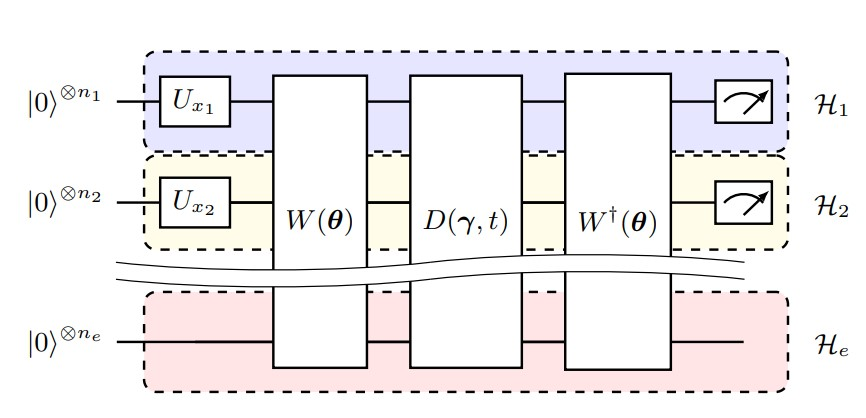

In [ ]:
def D(gamma: torch.Tensor, n: torch.Tensor, h: int = None, get_probs: bool = False) -> None:
    """Generates an n_qubit quantum circuit implementing a h-local parameterized
    diagonal unitary according to Walsh-Fourier Series approximation
    """
    n_qubits = int(torch.sum(n))
    if h is None:
        h = n_qubits
    cnt = 0
    for i in range(1, h + 1):
        for comb in combinations(range(n_qubits), i):
            if len(comb) == 1:
                qml.RZ(gamma[cnt], wires=[comb[0]])
                cnt += 1
            elif len(comb) > 1:
                cnots = [comb[i : i + 2] for i in range(len(comb) - 1)]
                for j in cnots:
                    qml.CNOT(wires=j)
                qml.RZ(gamma[cnt], wires=[comb[-1]])
                cnt += 1
                for j in cnots[::-1]:
                    qml.CNOT(wires=j)
    if get_probs:
        return qml.probs(wires=range(n_qubits))

In [ ]:

def U(X,wires):
  '''
  Quantum encoding of classical states using basis embedding
  '''
  return qml.BasisEmbedding(X,wires)

def W(weights, wires):
  return qml.StronglyEntanglingLayers(weights,wires)


In [ ]:
n_qubits = 5     # 1 qubit per 2 system channels and 3 environment qubits
dev = qml.device("default.qubit", wires=n_qubits, shots=None)

@qml.qnode(dev, interface="torch", diff_method="backprop")
def QNet(
    X: int,
    n: torch.Tensor,
    k: float,
    channel_id: int,
    alpha: torch.Tensor,
    gamma: torch.Tensor,
    h: int,
    U: callable,
    W: callable,
    D: callable,
    mode: str = 'probs'
) -> list:

    """
    Trainable ansatz to compute T_ij(k)
    Creates parametrized circuit of the form WDW†U applied to the (system+env) state.
    Encodes each time series state X_i[t] ∈ {0,1} using Basis Encoding.
    Outputs expected value of partial trace of composite circuit over the
    target channel of projection over target basis.

    """
    n_qubits = int(torch.sum(n))
    # Convert the state to its binary format representation
    encoding_length = int(n[channel_id])
    binary_X = [int(x) for x in "{0:b}".format(int(X))]
    pad_binary_X = [0]*(encoding_length-len(binary_X))
    pad_binary_X.extend(binary_X)

    # Apply Basis Encoding to system channel : channel_id ; rest of the qubits have default initialization of |0>
    if channel_id == 0:
      start_qbit = 0
    else:
      start_qbit = int(torch.sum(n[0:channel_id]))
    end_qbit = start_qbit + len(pad_binary_X)
    U(binary_X, wires=range(start_qbit,end_qbit))


    # Create Ansatz WDW† extending over all the qubits of the circuit
    qml.adjoint(W)(alpha, wires=range(n_qubits))
    D(gamma*k, n, h)
    W(alpha, wires=range(n_qubits))

    if mode == 'probs':
      # Measure the probabilities of system sub-channel channel_id only, of producing different target basis states
      return(qml.probs(wires=range(start_qbit, end_qbit)))
    else:
      # Return the density matrix of system qubits quantum state tracing out all environment qubits
      return qml.density_matrix(wires=range(0, int(torch.sum(n[:-1]))))


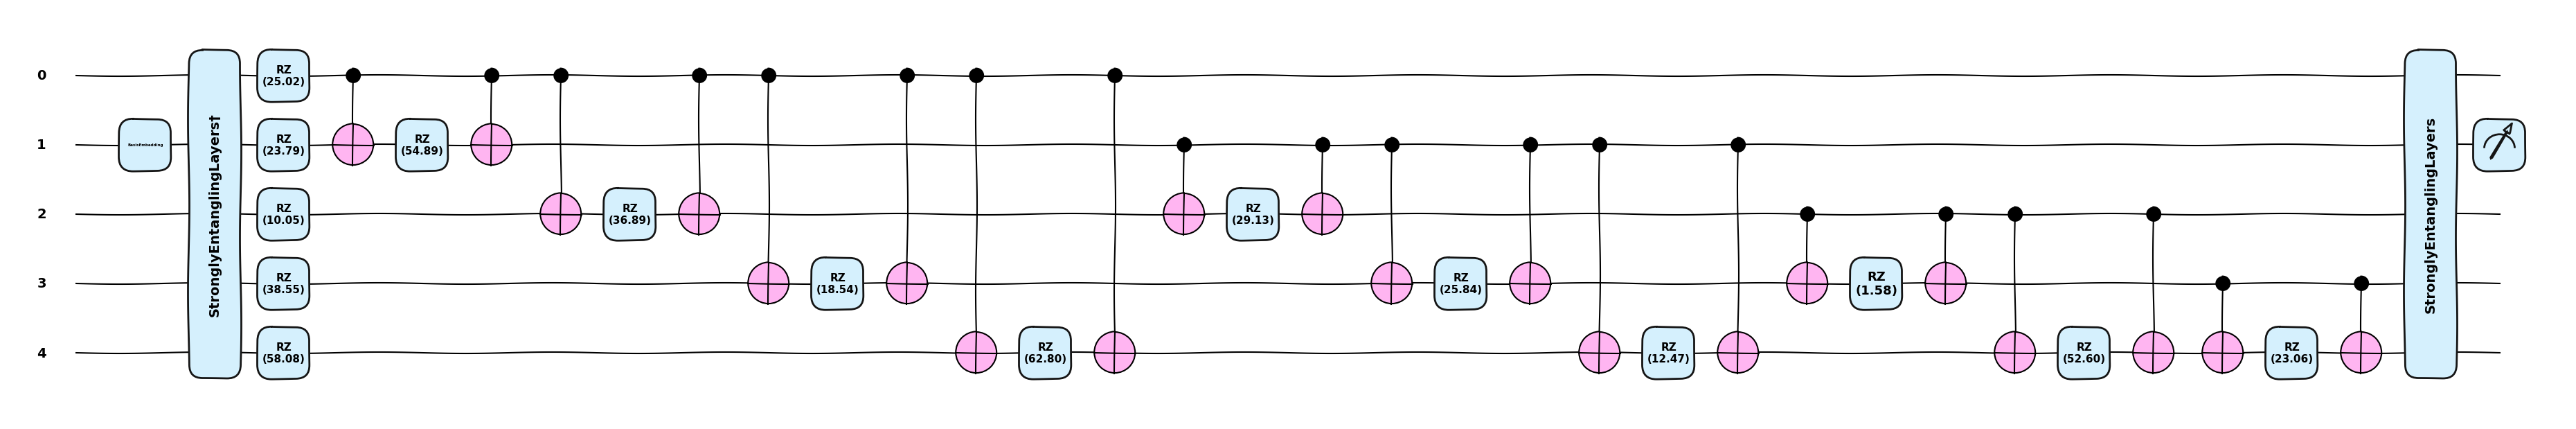

In [ ]:
init_alpha=torch.rand(qml.StronglyEntanglingLayers.shape(2, 5))
init_gamma=torch.rand(64)
alpha=(2 * torch.pi * init_alpha).clone().detach()
gamma=(2 * torch.pi * init_gamma).clone().detach()
fig,ax = qml.draw_mpl(QNet, decimals=2, style='pennylane')(X=1,
                                        n=torch.tensor([1,1,3]),
                                        k=10,
                                        channel_id=1,
                                        alpha=alpha,
                                        gamma=gamma,
                                        h=2,
                                        U=U,
                                        W=W,
                                        D=D,
                                        mode='probs')
fig.show()

In [ ]:

def callable_aijkd(
    QNet: callable,
    n: torch.Tensor,
    h: int,
    U: callable,
    W: callable,
    D: callable,
    ) -> callable:

    a_ijkd = lambda X, channel_id, k, alpha, gamma: QNet (X, n, k, channel_id, alpha,gamma, h, U, W, D)
    return a_ijkd

###Build the KLD loss function

In [ ]:

def minibatch_loss(
    a_ijkd: callable,
    minibatch: list,
    channels: int,
    n_bins: int,
    alpha: torch.Tensor,
    gamma: torch.Tensor
    ) -> torch.Tensor:

    '''
      Evaluates the Kullback-Leibler divergence as the loss measure for 1 minibatch
    '''

    X, channel_id, k, T_ijkd = minibatch
    loss = torch.zeros(len(k))
    for i in range(len(k)):
      a = a_ijkd(int(X[i]), int(channel_id[i]), int(k[i]), alpha, gamma)
      for s in range(n_bins):
        #loss.data[i] += a[s]*torch.log(a[s]/T_ijkd[s][i])
        loss[i] += T_ijkd[s][i]*torch.log(T_ijkd[s][i]/a[s])
    return loss.mean()

### Train the Q network

In [ ]:
def initialize_parameters(W: callable,
                          W_layers: int,
                          n: torch.Tensor,
                          h: int,
                          seed: int = GLOBAL_SEED
                          ) -> dict:
    """
    Randomly generate initial parameters {alpha, gamma}. We need initial parameters for the
    variational circuit ansatz implementing W(alpha) and D(gamma).
    """
    torch.manual_seed(seed)
    n_qubits = int(torch.sum(n))
    init_alpha = torch.randn(W.shape(W_layers, n_qubits))
    gamma_length = 0
    if h<=n_qubits:
      for r in range(1,h+1):
        gamma_length += comb(n_qubits, r)
    else:
      gamma_length = 2**n_qubits-1
    init_gamma = torch.randn(gamma_length)
    init_params = {
        "alpha": (2*torch.pi*init_alpha).clone().detach().requires_grad_(True),
        "gamma": (2*torch.pi*init_gamma).clone().detach().requires_grad_(True)
    }
    return init_params

In [ ]:
def train_model_gradients(
    lr: float,
    channels: int,
    n_bins: int,
    init_params: dict,
    pytorch_optimizer: callable,
    cycler: DataGetter,
    n_minibatches: int,
    epochs: int,
    a_ijkd: callable,
    seed=GLOBAL_SEED,
    print_intermediate=True,
) -> dict:

    """
    Trains the model (minimize the cost function) with respect to the
    variational parameters using gradient-based training.
    """
    torch.manual_seed(seed)
    min_loss = 10**5
    opt = pytorch_optimizer(init_params.values(), lr=lr)
    alpha = init_params["alpha"]
    gamma = init_params["gamma"]
    results_dict = {
        "final_params": {
            "alpha": opt.param_groups[0]["params"][0],
            "gamma": opt.param_groups[0]["params"][1],
        },
        "best_params": {
            "alpha": opt.param_groups[0]["params"][0],
            "gamma": opt.param_groups[0]["params"][1],
        }
    }
    def closure():
        opt.zero_grad()
        loss = minibatch_loss(a_ijkd, next(cycler), channels, n_bins, alpha, gamma)
        loss.backward()
        return loss

    loss_history = []
    for i in range(epochs):
      for j in range(n_minibatches):
        loss = opt.step(closure)
        loss_history.append(loss)
        if print_intermediate:
          if (i*n_minibatches+j) % 10 == 0:
            print(f"Iteration number {i*n_minibatches+j}\n Current loss {loss}\n")
        else:
          if j==n_minibatches-1:
            print(f"Epoch: {i}\n Current loss: {loss}\n")
        if loss.data < min_loss:
          results_dict['best_params']['alpha'] = opt.param_groups[0]["params"][0]
          results_dict['best_params']['gamma'] = opt.param_groups[0]["params"][1]
    results_dict['final_params']['alpha'] = opt.param_groups[0]["params"][0]
    results_dict['final_params']['gamma'] = opt.param_groups[0]["params"][1]
    results_dict['loss history'] = loss_history
    return results_dict

In [ ]:
def training_workflow(
    U: callable,
    W: callable,
    D: callable,
    QNet: callable,
    n: torch.Tensor,
    h: int,
    a_ijkd: callable,
    W_layers: int,
    timestamps : int,
    channels : int,
    dt : float,
    mu : torch.Tensor,
    sigma : torch.Tensor,
    n_bins: int,
    Tk: torch.Tensor,
    num_segments: int,
    batch_size: int,
    pytorch_optimizer: callable,
    lr: float,
    epochs: int,
) -> dict:
    """
    Combine all of the previously defined functions into an entire training workflow,
    including (1) generating synthetic data, (2) packaging it into training cyclers
    (3) preparing the quantum functions, making a quantum computer call to calculate
    the loss function and (4) optimizing the loss function with gradient based
    optimizers on classical computers
    """

    X = generate_series(timestamps, channels, dt, mu, sigma)
    X_diff = calculate_first_order_diff(X.T)
    X_sax = get_SAX_symbols(X_diff, n_bins=n_bins, num_segments=num_segments)
    T_ijk = create_transition_matrix(X_sax, Tk, channels)
    Xtr = atomize_training_set(X_sax, Tk, T_ijk, channels, n_bins)
    train_size = len(Xtr)
    n_minibatches = math.ceil(train_size/batch_size)
    cycler = get_training_cycler(Xtr, batch_size)
    init_params = initialize_parameters(W, W_layers, n, h)
    a = a_ijkd(QNet,n,h,U,W,D)
    results_dict = train_model_gradients(
        lr,
        channels,
        n_bins,
        init_params,
        pytorch_optimizer,
        cycler,
        n_minibatches,
        epochs,
        a,
        print_intermediate=True)
    return results_dict

In [ ]:
general_options = {
    "U": qml.BasisEmbedding,
    "W": qml.StronglyEntanglingLayers,
    "D": D,
    "QNet": QNet,
    "n": torch.Tensor([1,1,3]),
    "h": 2,
    "a_ijkd": callable_aijkd,
    "W_layers": 2,
    "timestamps" : 200,
    "channels" : 2,
    "dt" : 0.01,
    "mu" : torch.Tensor([-1,-2]),
    "sigma" : torch.Tensor([[1, -0.5],[-0.5, 1]]),
    "n_bins": 2,
    "Tk": torch.Tensor([1,2,10,30,50]),
    "num_segments": 200

}

training_options = {
    "batch_size": 30,
    "pytorch_optimizer": torch.optim.Adam,
    "lr": 0.01,
    "epochs": 100
}

training_options.update(general_options)

In [ ]:
results_dict = training_workflow(**training_options)

Iteration number 0
 Current loss 0.012242917359145702

Iteration number 10
 Current loss 0.0033156867235277832

Iteration number 20
 Current loss 0.0008846997746387085

Iteration number 30
 Current loss 0.00044439142397764117

Iteration number 40
 Current loss 0.0003224164302546104

Iteration number 50
 Current loss 0.00017751808581963776

Iteration number 60
 Current loss 9.889369433579733e-05

Iteration number 70
 Current loss 5.108964882363351e-05

Iteration number 80
 Current loss 2.938053827529123e-05

Iteration number 90
 Current loss 1.6408214848990174e-05



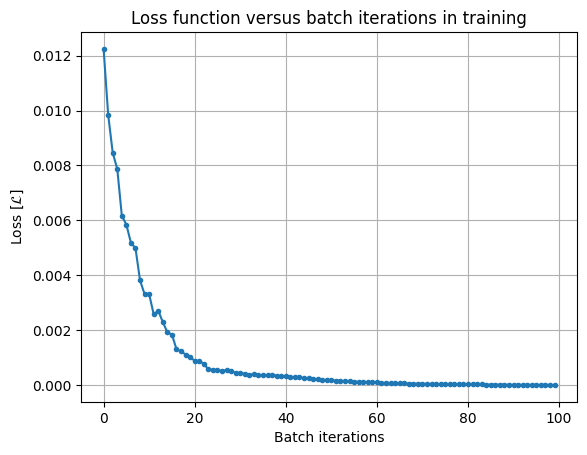

In [ ]:
plt.figure()
results = [float(loss.detach()) for loss in results_dict["loss history"] ]
plt.plot(results, ".-")
plt.ylabel("Loss [$\mathcal{L}$]")
plt.xlabel("Batch iterations")
plt.title("Loss function versus batch iterations in training")
plt.grid()

In [ ]:
best_params = results_dict['best_params']
alpha, gamma = best_params['alpha'].data, best_params['gamma'].data

###Visualizing Cost function (KL divergence) surface

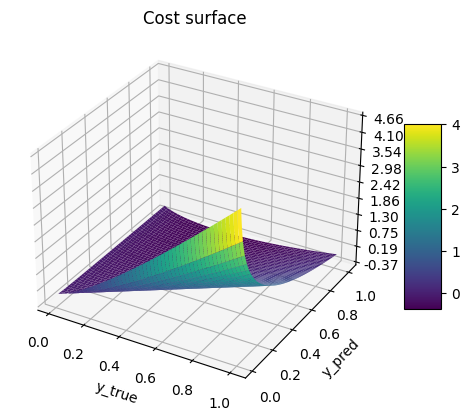

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator, FormatStrFormatter

def cost_function(y_true, y_pred):
  return y_true*np.log(y_true/y_pred)

def generate_surface(cost_function):
    Z = []
    Z_assembler = []

    X = np.arange(0.01, 1.01, 0.001)
    Y = np.arange(0.01, 1.01, 0.001)
    X, Y = np.meshgrid(X, Y)
    for x in X[0, :]:
        for y in Y[:, 0]:
            Z_assembler.append(cost_function(y,x))
        Z.append(Z_assembler)
        Z_assembler = []

    Z = np.asarray(Z)
    return Z

def plot_surface(surface):
    X = np.arange(0.01, 1.01, 0.001)
    Y = np.arange(0.01, 1.01, 0.001)
    X, Y = np.meshgrid(X, Y)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, surface, cmap="viridis", linewidth=0, antialiased=True)
    #ax.set_zlim(0, 1)
    plt.xlabel('y_true')
    plt.ylabel('y_pred')
    plt.title('Cost surface')
    ax.zaxis.set_major_locator(LinearLocator(10))
    ax.zaxis.set_major_formatter(FormatStrFormatter("%.02f"))
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()


global_surface = generate_surface(cost_function)
plot_surface(global_surface)

## Generate New δxi Values using the best parameters of the trained circuit

In [ ]:
def generate_sequence(X_init: list,
                      U: callable,
                      W: callable,
                      D: callable,
                      QNet: callable,
                      n: torch.Tensor,
                      h: int,
                      best_params: dict,
                      calls: int,
                      n_bins: int,
                      channels: int,
                      timesteps: int) -> torch.Tensor:


    Tk = torch.arange(1,timesteps)
    alpha, gamma = best_params['alpha'].data, best_params['gamma'].data
    generated_seq = torch.zeros((calls, channels, timesteps))
    for call in range(calls):
      for channel in range(channels):
        generated_seq[call, channel, 0] = X_init[channel]
        for k in Tk:
          A_ijkd = QNet(X_init[channel], n, k, channel, alpha, gamma, h, U, W, D)
          generated_seq[call, channel, k] = torch.argmax(A_ijkd)

    return generated_seq

In [ ]:
X_init = [int(X_sax[0][0]), int(X_sax[1][0])]
best_params = results_dict['best_params']
generated_seq = generate_sequence(X_init, U, W, D, QNet, n=torch.Tensor([1,1,3]), h=2, best_params=best_params, calls=10, n_bins=2, channels=2, timesteps=200)


In [ ]:
generated_seq[1,:,:]

tensor([[0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
         1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
         1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
         1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
         0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
         1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
         0., 0.],
        [1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
         1

### Calculate mean and variance of quantum generated series

In [ ]:
def calculate_mean_var(generated_seq: torch.Tensor) -> torch.Tensor:
  '''
  Calculate mean/variance at each time step for every channel
  returns -> tensor(channel, timestep, 0: mean
                                       1: variance)
  '''
  channels, timesteps = generated_seq.shape[1], generated_seq.shape[-1]
  mean_var = torch.zeros((channels, timesteps, 2))
  for channel in range(channels):
    for t in range(timesteps):
      mean_var[channel,t,0], mean_var[channel,t,1] = torch.mean(generated_seq[:,channel,t]), torch.var(generated_seq[:,channel,t])
  return mean_var

In [ ]:
mean_var = calculate_mean_var(generated_seq)
mean_var[:,:,0]

tensor([[0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1.,
         1., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
         1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 1., 0.,
         1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1.,
         0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
         0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0.,
         1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0.,
         0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
         1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0.,
         0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1.,
         0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
         0., 0.],
        [1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 0.,
         1

***With classical simulation, we won't get different generated series with each call; the device needs to run on a quantum hardware for that***

### Model Performance metrics

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score

def performance_analysis(actual: torch.Tensor, generated: torch.Tensor) -> dict:
    channels = actual.shape[0]
    final_results = {}
    for channel in range(channels):
      results = {}
      results['MSE'] = mean_squared_error(actual[channel], generated[0,channel,:])
      results['Accuracy'] = accuracy_score(actual[channel], generated[0,channel,:])
      results['F1 Score'] = f1_score(actual[channel], generated[0,channel,:])
      final_results[f'Results for Channel {channel}'] = results
    return final_results


In [ ]:
performance_analysis(X_sax, generated_seq)

{'Results for Channel 0': {'MSE': 0.48,
  'Accuracy': 0.52,
  'F1 Score': 0.5428571428571428},
 'Results for Channel 1': {'MSE': 0.49,
  'Accuracy': 0.51,
  'F1 Score': 0.4673913043478261}}

### Visualizing histograms of state frequency distribution

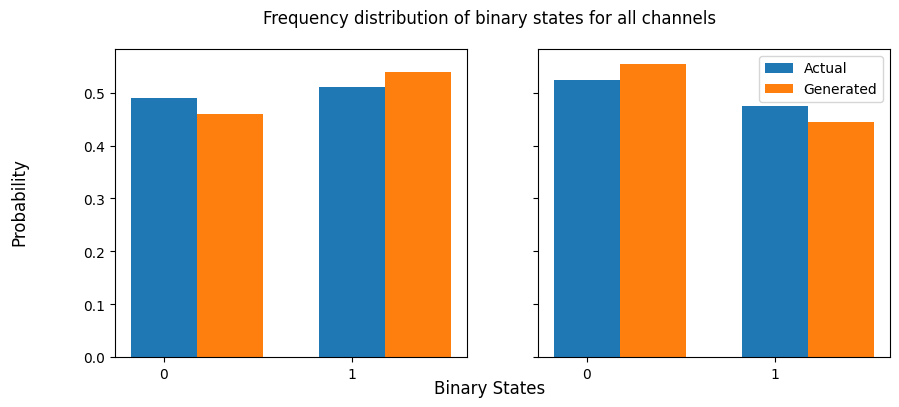

In [ ]:
binary_states = [str(x) for x in range(n_bins)]
# Calculate distribution counts for both channels (actual and generated series)
ch0_actual = [float(1-torch.sum(X_sax[0])/len(X_sax[0])),float(torch.sum(X_sax[0])/len(X_sax[0]))]
ch0_gen = [float(1-torch.sum(generated_seq[0,0,:])/len(generated_seq[0,0,:])),float(torch.sum(generated_seq[0,0,:])/len(generated_seq[0,0,:]))]
ch1_actual = [float(1-torch.sum(X_sax[1])/len(X_sax[1])),float(torch.sum(X_sax[1])/len(X_sax[1]))]
ch1_gen = [float(1-torch.sum(generated_seq[0,1,:])/len(generated_seq[0,1,:])),float(torch.sum(generated_seq[0,1,:])/len(generated_seq[0,1,:]))]

bar_width = 0.35

fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10, 4))
# Create bar chart for the actual distribution
ax1.bar(binary_states, ch0_actual, width=bar_width, label='Actual')
# Calculate the x positions for the bars in the second distribution
x_positions = [x + bar_width for x in range(len(binary_states))]
# Create bar chart for the genearted distribution
ax1.bar(x_positions, ch0_gen, width=bar_width, label='Generated')

# Similarly for channel 1
ax2.bar(binary_states, ch1_actual, width=bar_width, label='Actual')
x_positions = [x + bar_width for x in range(len(binary_states))]
ax2.bar(x_positions, ch1_gen, width=bar_width, label='Generated')

# Add labels and title
fig.supxlabel('Binary States')
fig.supylabel('Probability')
fig.suptitle('Frequency distribution of binary states for all channels')
# Add a legend to differentiate between the two distributions
plt.legend()

# Display the chart
plt.show()


###NON-MARKOVIANITY

In [ ]:
def get_reduced_dm(X_init: int,
                   n: torch.Tensor(),
                   k: int,
                   alpha: torch.Tensor(),
                   gamma: torch.Tensor(),
                   h: int,
                   U: callable,
                   W: callable,
                   D: callable,
                   QNet: callable,
                   channels: int) -> torch.Tensor():
    '''
    Calculate the reduced density matrices of individual time series channels at some timestep k
    '''
    reduced_density_matrices = []
    # Calculate the combined density matrix of the system variable by setting mode parameter of QNet to 'matrix'
    density_matrix = QNet(X_init, n, k, 0, alpha, gamma, h, U, W, D, mode='matrix')
    # Fetch the reduced density matrix for each channel
    for c in range(channels):
      reduced_density_matrices.append(qml.math.reduce_dm(density_matrix, indices=[c]))
    return torch.stack(reduced_density_matrices)

In [ ]:
def trace_distance(state1: torch.Tensor,
                   state2: torch.Tensor) -> float:
    '''
      D = 0.5*|Tr(ρ1-ρ2)| = 0.5*∑|λi|
      where,
             |A| = (A†A)**0.5
             λi: eigen-values of (ρ1-ρ2)
    '''
    delta_state = state1 - state2
    eigvals = torch.linalg.eigvals(delta_state)
    D = 0
    for eig in eigvals:
      D += abs(eig)
    return float(0.5*D)


In [ ]:
def cumulative_degree_nonmarkovianity(D: torch.tensor,
                                      t: int) -> float:
    '''
    Measures the cumulative degree of non-Markovianity of the given process up until time t.
    N (Φ, t) = ∑ dt*D(ρ1(t), ρ2(t))
    '''
    if t>len(D):
      t = len(D)
    return float(torch.sum(D[:t+1]))

In [ ]:
def degree_nonmarkovianity(D: torch.tensor) -> list:
  '''
  σ(t, ρ1,2(0)) = d/dt D(ρ1(t), ρ2(t))
  if σ(t) > 0 : non-Markovian process ;
  σ(t) : degree of non-Markovianity
  '''
  gradients = torch.gradient(input=D)
  return gradients[0].tolist()


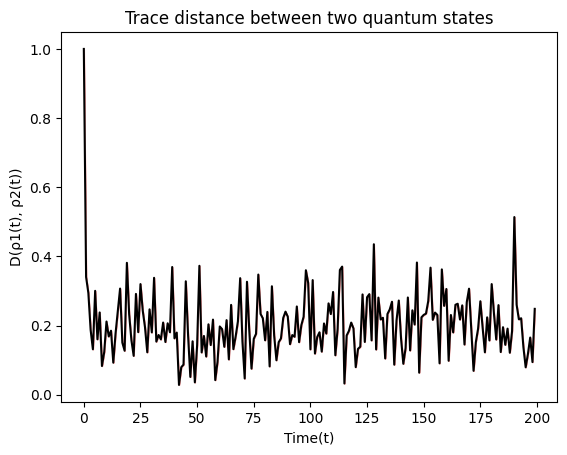

In [ ]:
# Initialize required params
X_init = 1  # Perfectly distinguishable states 0 & 1
n=torch.Tensor([1,1,3])
timesteps = 200
h=2
channels=2
calls = 20
# Fetch the best params of the trained model
best_params = results_dict['best_params']
alpha, gamma = best_params['alpha'].data, best_params['gamma'].data

# Calculate trace distance (mean & std) between two system channels for different timesteps
trace_dist = torch.zeros((calls, timesteps))
for call in range(calls):    # Obtain the measurement statistics via multiple calls/readouts
  for k in range(0,timesteps):
    reduced_density_matrices = get_reduced_dm(X_init, n, k, alpha, gamma, h, U, W, D, QNet, channels)
    trace_dist[call][k] = trace_distance(reduced_density_matrices[0], reduced_density_matrices[1])
std_mean = torch.std_mean(trace_dist,0)
trace_dist_std, trace_dist_mean =  pd.DataFrame(2*std_mean[0]), pd.DataFrame(std_mean[1])

# Plot the mean and std of trace distances
under_line = (trace_dist_mean - trace_dist_std)[0]
over_line = (trace_dist_mean + trace_dist_std)[0]
plt.plot(trace_dist_mean, color='black')
plt.fill_between(trace_dist_std.index, under_line,
                  over_line, color='red', alpha=.3)
plt.title('Trace distance between two quantum states')
plt.xlabel('Time(t)')
plt.ylabel('D(ρ1(t), ρ2(t))')
plt.show()


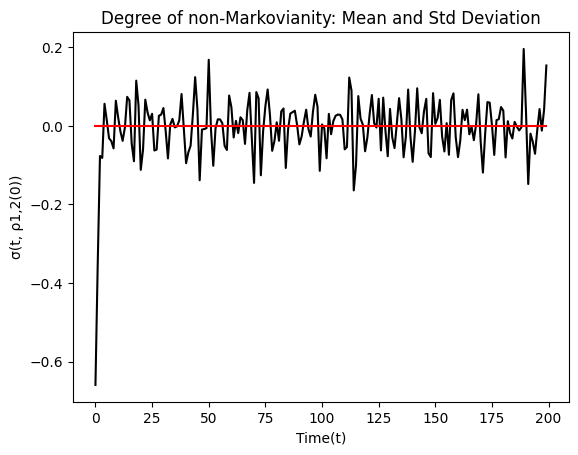

In [ ]:
trace_dist_grad = torch.tensor([degree_nonmarkovianity(trace_dist[call,:]) for call in range(calls)])
trace_dist_grad_stdmean = torch.std_mean(trace_dist_grad,0)
trace_dist_grad_std, trace_dist_grad_mean = pd.DataFrame(trace_dist_grad_stdmean[0]), pd.DataFrame(trace_dist_grad_stdmean[1])
plt.plot(trace_dist_grad_mean, color='black')
plt.plot(trace_dist_grad_std, color='red')
plt.title('Degree of non-Markovianity: Mean and Std Deviation')
plt.xlabel('Time(t)')
plt.ylabel('σ(t, ρ1,2(0))')
plt.show()

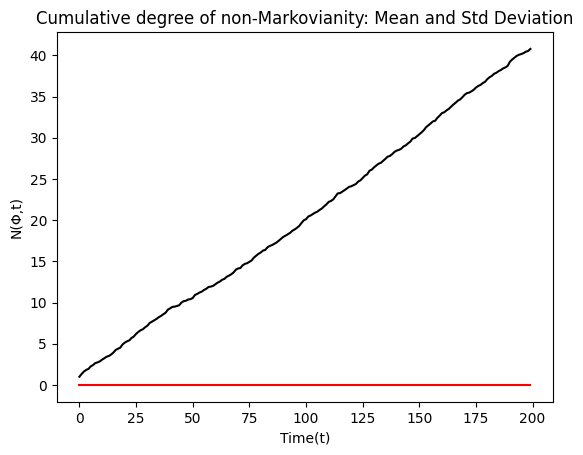

In [ ]:
trace_dist_cum = torch.tensor([[cumulative_degree_nonmarkovianity(trace_dist[call,:], t) for t in range(timesteps)] for call in range(calls)])
trace_dist_cum_stdmean = torch.std_mean(trace_dist_cum,0)
trace_dist_cum_std, trace_dist_cum_mean = pd.DataFrame(trace_dist_cum_stdmean[0]), pd.DataFrame(trace_dist_cum_stdmean[1])
plt.plot(trace_dist_cum_mean, color='black')
plt.plot(trace_dist_cum_std, color='red')
plt.title('Cumulative degree of non-Markovianity: Mean and Std Deviation')
plt.xlabel('Time(t)')
plt.ylabel('N(Φ,t)')
plt.show()